Cluster Interconnectivity Analysis Script

This script analyzes and visualizes the interconnectivity between academic paper clusters.
It processes citation networks to show how different research clusters reference each other,
creating matrices and heatmap visualizations.

The script:

1. Loads cluster and reference data from pickle and JSON files
2. Creates interconnectivity matrices showing citation patterns between clusters
3. Analyzes internal vs. external reference patterns for each cluster
4. Generates heatmap visualizations of the interconnectivity

Requirements:

- Environment variables in .env file: DATA_DIR, OUTPUT_DIR
- Input data:
  - Pickled DataFrame with cluster assignments and reference data
  - JSON files with cluster labels and legend information

Author: Lukas Westphal
Date: April 16, 2025


In [11]:
import json
import os
from collections import defaultdict
from datetime import datetime
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [14]:

from pandas import Timestamp


class ClusterAnalyzer:
    """
    Class to handle cluster analysis operations.

    This class provides methods for analyzing interconnectivity between
    academic paper clusters based on citation networks. It loads data,
    extracts cluster categories, creates interconnectivity matrices,
    analyzes reference patterns, and generates visualizations.

    The analysis focuses on how different research clusters reference each other,
    measuring both internal (within-cluster) and external (between-cluster) citation
    patterns to identify knowledge flow and research community structures.
    """

    def __init__(self, data_dir: str, output_dir: str, parameter: str = "alpha0.3_k10_res0.002"):
        """Initialize with paths and parameters."""
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.parameter = parameter
        self.cluster_col = f"cluster_{parameter}"
        self.df = None
        self.cluster_label_dict = None
        self.legend = None

    def load_data(self):
        """
        Load the dataset and reference files.

        This method loads the main DataFrame, cluster labels, and legend files
        required for the analysis. It ensures that all necessary data is available
        for subsequent operations.

        Returns:
            self: The ClusterAnalyzer instance with loaded data.
        """
        # Load DataFrame
        pdf = os.path.join(self.data_dir, "08-analysis-data/2025/df_analysis.pkl")
        self.df = pd.read_pickle(pdf)
        print(f"DataFrame loaded with rows: {len(self.df)}")

        # Load cluster labels
        labels_path = os.path.join(
            self.output_dir,
            "cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json"
        )
        with open(labels_path, "r") as f:
            self.cluster_label_dict = json.load(f)
        print(f"Cluster labels loaded with {len(self.cluster_label_dict)} entries.")

        # Load legend
        legend_path = os.path.join(
            self.output_dir,
            "cluster-qualifications_2025/cluster-label-tree/legend_labels_2025.json"
        )
        with open(legend_path, "r") as f:
            self.legend = json.load(f)
        print(f"Legend loaded with {len(self.legend)} entries.")
        return self

    @staticmethod
    def _get_dict_keys(obj):
        """Extract all dictionary keys from nested structures."""
        if isinstance(obj, dict):
            # Get keys from current level and recurse for nested structures
            return list(obj.keys()) + [k for v in obj.values() for k in ClusterAnalyzer._get_dict_keys(v)]
        elif isinstance(obj, list):
            # Recurse for each item in the list
            return [k for item in obj for k in ClusterAnalyzer._get_dict_keys(item)]
        else:
            # Base case: not a dict or list
            return []

    def create_cluster_interconnectivity_matrix(self, cluster_subset_keys=None) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Create matrices showing the interconnectivity between clusters.

        Args:
            cluster_subset_keys (list, optional): A subset of cluster keys to limit the calculation.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]:
                - Edge counts matrix (raw counts)
                - Normalized interconnectivity matrix
        """
        # Get unique clusters and create mappings
        clusters = sorted(self.df[self.cluster_col].unique(), key=int)

        # Filter clusters if a subset is provided
        if cluster_subset_keys is not None:
            clusters = [c for c in clusters if int(c) in cluster_subset_keys]
        n_clusters = len(clusters)

        if n_clusters == 0:
            raise ValueError("No clusters found in the data or the subset provided.")

        # Create a mapping of eid to cluster for faster lookups
        eid_to_cluster = self.df.set_index('eid')[self.cluster_col].to_dict()

        # Create a mapping of cluster to index for faster lookups
        cluster_to_idx = {cluster: idx for idx, cluster in enumerate(clusters)}

        # Initialize edge count matrix
        edge_counts = np.zeros((n_clusters, n_clusters))

        # Pre-process and organize all references by source cluster
        references_by_cluster = defaultdict(list)

        # Build a list of all references with their source clusters
        for _, row in self.df.iterrows():
            if row[self.cluster_col] in clusters:  # Only process rows in the subset
                cluster_idx = cluster_to_idx[row[self.cluster_col]]
                if isinstance(row["filtered_reference_eids"], list):
                    references_by_cluster[cluster_idx].extend(row["filtered_reference_eids"])
                else:
                    print(f"Unexpected reference type: {type(row['filtered_reference_eids'])}")

        # Process all references at once per cluster
        for src_cluster_idx, reference_eids in references_by_cluster.items():
            # Filter references to only those in our dataset and subset
            valid_refs = [eid for eid in reference_eids if eid in eid_to_cluster and eid_to_cluster[eid] in clusters]

            if valid_refs:
                # Get the target clusters for all references
                target_clusters = [eid_to_cluster[eid] for eid in valid_refs]

                # Convert target clusters to indices
                target_indices = [cluster_to_idx[c] for c in target_clusters]

                # Count occurrences of each target cluster
                for tgt_idx in target_indices:
                    edge_counts[src_cluster_idx, tgt_idx] += 1

        # Create DataFrames with sorted cluster labels
        cluster_labels = [f"Cluster {c}" for c in clusters]
        edge_counts_df = pd.DataFrame(
            edge_counts,
            index=cluster_labels,
            columns=cluster_labels
        )

        # Calculate cluster sizes once (more efficient)
        cluster_sizes = self.df[self.cluster_col].value_counts()
        # Sort the index numerically and filter by subset
        cluster_sizes = cluster_sizes.reindex(sorted(cluster_sizes.index, key=int))
        cluster_sizes = cluster_sizes[cluster_sizes.index.isin(clusters)].values

        # Create normalized matrix using broadcasting
        normalized_counts = np.zeros((n_clusters, n_clusters))
        size_matrix = np.outer(cluster_sizes, cluster_sizes)
        mask = size_matrix > 0
        normalized_counts[mask] = edge_counts[mask] / size_matrix[mask]

        normalized_df = pd.DataFrame(
            normalized_counts,
            index=cluster_labels,
            columns=cluster_labels
        )

        return edge_counts_df, normalized_df

    def analyze_cluster_interconnectivity(self) -> Dict[str, Dict[str, float]]:
        """
        Analyze the interconnectivity between clusters.

        Returns:
            Dict[str, Dict[str, float]]: Metrics for each cluster, including internal and external ratios.
        """
        # Get unique clusters
        clusters = sorted(self.df[self.cluster_col].unique())

        # Create a mapping of eid to cluster for faster lookups
        eid_to_cluster = self.df.set_index('eid')[self.cluster_col].to_dict()

        # Pre-compute all edge information at once
        edge_data = defaultdict(lambda: {"internal": 0, "external": 0})

        # Group by cluster for more efficient processing
        cluster_groups = self.df.groupby(self.cluster_col)

        for cluster, cluster_df in cluster_groups:
            # Process all rows in a cluster at once
            for _, row in cluster_df.iterrows():
                if isinstance(row["filtered_reference_eids"], list) and row["filtered_reference_eids"]:
                    # Filter to valid references
                    valid_refs = [eid for eid in row["filtered_reference_eids"] if eid in eid_to_cluster]

                    if valid_refs:
                        # Get target clusters for all references at once
                        target_clusters = [eid_to_cluster[eid] for eid in valid_refs]

                        # Count internal vs external references
                        internal_count = sum(1 for c in target_clusters if c == cluster)
                        external_count = len(target_clusters) - internal_count

                        edge_data[cluster]["internal"] += internal_count
                        edge_data[cluster]["external"] += external_count

        # Calculate metrics
        cluster_metrics = {}
        for cluster in clusters:
            internal_edges = edge_data[cluster]["internal"]
            external_edges = edge_data[cluster]["external"]
            total_edges = internal_edges + external_edges

            internal_ratio = internal_edges / total_edges if total_edges > 0 else 0
            external_ratio = external_edges / total_edges if total_edges > 0 else 0

            cluster_metrics[cluster] = {
                "size": len(self.df[self.df[self.cluster_col] == cluster]),
                "internal_edges": internal_edges,
                "external_edges": external_edges,
                "internal_ratio": internal_ratio,
                "external_ratio": external_ratio,
            }

        return cluster_metrics

    def print_metrics_summary(self, metrics_df):
        """Print summary statistics from metrics dataframe."""
        print("\nCluster Interconnectivity Summary:")
        print("-" * 50)
        print(f"Total number of clusters: {len(metrics_df)}")
        print(f"Average cluster size: {metrics_df['size'].mean():.2f}")
        print(f"Average internal edge ratio: {metrics_df['internal_ratio'].mean():.3f}")
        print(f"Average external edge ratio: {metrics_df['external_ratio'].mean():.3f}")

    def plot_heatmap(self, df_to_plot, cluster_type="All", diag_excluded=True, cap_max_percentile=None):
        """
        Plot heatmap for cluster interconnectivity.

        Args:
            df_to_plot (pd.DataFrame): DataFrame to visualize as a heatmap.
            cluster_type (str): Type of clusters to label the heatmap.
            diag_excluded (bool): Whether to exclude diagonal values.
            cap_max_percentile (float, optional): Maximum percentile for color scale.
        """
        # Set figure size based on matrix dimensions
        figsize = (25, 25) if cluster_type == "All" else (20, 15)

        # Create labels for axes
        clusters = [cluster.replace('Cluster ', '') for cluster in df_to_plot.index.tolist()]
        x_labels = [self.cluster_label_dict[cluster] for cluster in clusters]
        y_labels = [self.cluster_label_dict[cluster] for cluster in clusters]

        # Exclude diagonal if specified
        if diag_excluded:
            np.fill_diagonal(df_to_plot.values, np.nan)

        # Set maximum value for color scale
        if cap_max_percentile:
            vmax = np.nanpercentile(df_to_plot.values, cap_max_percentile)
        else:
            vmax = df_to_plot.max().max()

        # Create plot
        plt.figure(figsize=figsize)
        heatmap = sns.heatmap(df_to_plot, annot=False, xticklabels=x_labels, yticklabels=y_labels,
                              cmap="viridis", vmin=0, vmax=vmax, cbar_kws={'label': "Interconnectivity"})

        title = f"Edge Counts Between {cluster_type} Clusters"
        plt.title(title)
        plt.xlabel("Target Clusters")
        plt.ylabel("Source Clusters")
        plt.tight_layout()

        # Save figure
        heatmap_filename = f"heatmap_{cluster_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        output_path = self.output_dir
        plt.savefig(os.path.join(output_path, heatmap_filename), dpi=400)
        plt.show()
        plt.close()


In [15]:

"""
Main function to run the cluster interconnectivity analysis.

This function:
1. Loads environment variables from .env file
2. Initializes the ClusterAnalyzer with appropriate paths
3. Loads data and extracts cluster categories
4. Creates interconnectivity matrices
5. Analyzes cluster interconnectivity metrics
6. Generates visualizations for all clusters and safety clusters

The function orchestrates the entire analysis pipeline and produces
both numerical metrics and visual heatmaps showing citation patterns.
"""
# Load environment variables

load_dotenv()

# Access environment variables
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUTPUT_DIR")


In [16]:

# Initialize analyzer
analyzer = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer.load_data()

# Create interconnectivity matrices
edge_counts_df, normalized_df = analyzer.create_cluster_interconnectivity_matrix()
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics = analyzer.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
metrics_df = pd.DataFrame.from_dict(cluster_metrics, orient="index")
metrics_df.index.name = "cluster"
metrics_df = metrics_df.sort_index()

# Print summary statistics
analyzer.print_metrics_summary(metrics_df)

DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


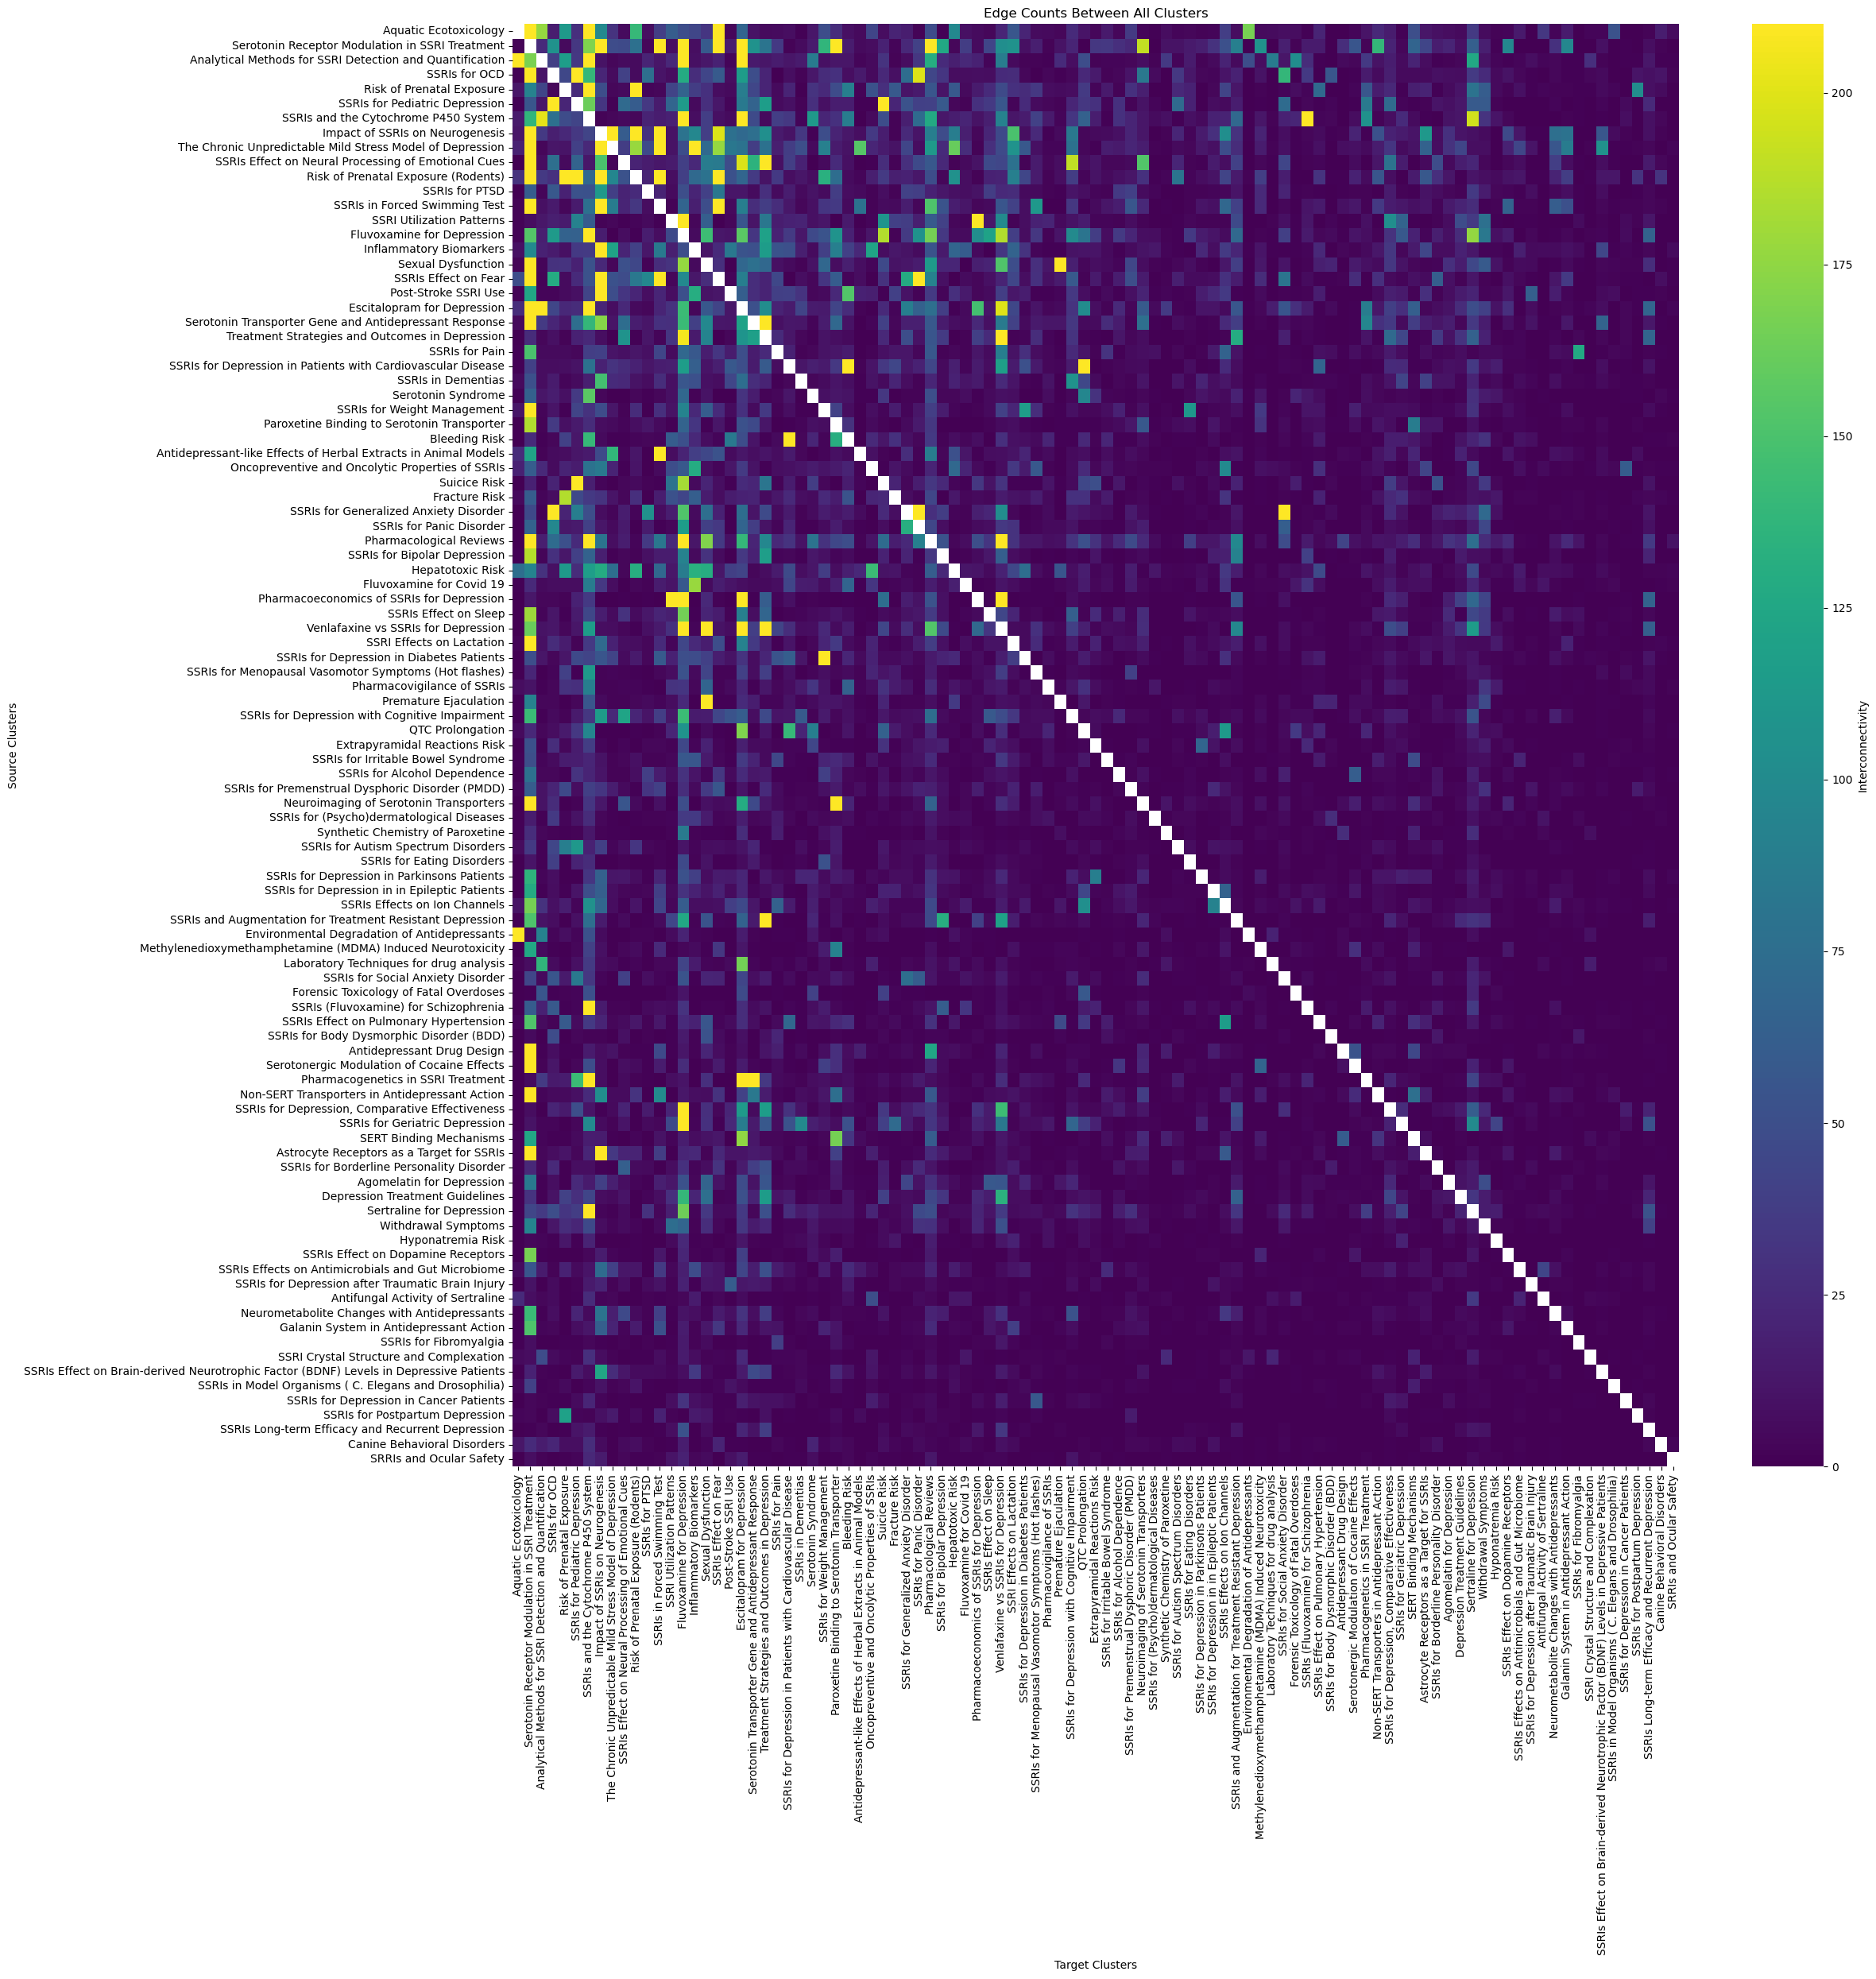

In [18]:
# Plot heatmap for all clusters
analyzer.plot_heatmap(edge_counts_df, "All", diag_excluded=True, cap_max_percentile=99)

# Subsets


In [19]:
def get_all_leaf_clusters(node, print_labels=False):
    """
    Recursively extracts all leaf cluster numbers from a hierarchical tree structure.
    
    Args:
        node: A dictionary or list node in the hierarchical tree
        
    Returns:
        list: A sorted list of all unique cluster numbers found in the leaves
    """
    clusters = []
    
    if isinstance(node, dict):
        # If this is a dictionary node, process each of its values
        for value in node.values():
            clusters.extend(get_all_leaf_clusters(value))
    
    elif isinstance(node, list):
        # If this is a list node, process each item in the list
        for item in node:
            clusters.extend(get_all_leaf_clusters(item))
    
    elif isinstance(node, dict) and len(node) == 1:
        # This is a leaf node with a single key-value pair
        # The key is the cluster number and the value is the description
        clusters.append(int(list(node.keys())[0]))
    
    # Handle the case where node is a dictionary with a single numeric key
    # This is the actual leaf node format in your data
    if isinstance(node, dict) and len(node) == 1 and all(k.isdigit() for k in node.keys()):
        clusters.append(int(list(node.keys())[0]))

    if print_labels:
        for cluster in clusters:
            print(f"Cluster {cluster}: {cluster_label_dict.get(str(cluster), 'Unknown')}")
        
    return sorted(list(set(clusters)))

In [20]:
# get legend 

legend = analyzer.legend
# get cluster labels
cluster_label_dict = analyzer.cluster_label_dict
# get cluster label tree
cluster_label_tree = analyzer._get_dict_keys(cluster_labels)

NameError: name 'cluster_labels' is not defined

In [21]:

# Get all leaf clusters from the Pharmacology branch
print("All clusters in Pharmacology:")
pharma_keys = get_all_leaf_clusters(legend['Pharmacology']['Pharmacodynamics']['Animal Models of Disorders'], print_labels=True)

All clusters in Pharmacology:
Cluster 8: The Chronic Unpredictable Mild Stress Model of Depression
Cluster 12: SSRIs in Forced Swimming Test
Cluster 17: SSRIs Effect on Fear
Cluster 71: Serotonergic Modulation of Cocaine Effects


In [22]:
print("All clusters in Geriatrics:")
geriatrics_keys = get_all_leaf_clusters(legend['Safety']['Special Populations']['Geriatrics'], print_labels=True)


All clusters in Geriatrics:
Cluster 18: Post-Stroke SSRI Use
Cluster 23: SSRIs for Depression in Patients with Cardiovascular Disease
Cluster 24: SSRIs in Dementias
Cluster 47: SSRIs for Depression with Cognitive Impairment
Cluster 58: SSRIs for Depression in Parkinsons Patients
Cluster 75: SSRIs for Geriatric Depression


DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


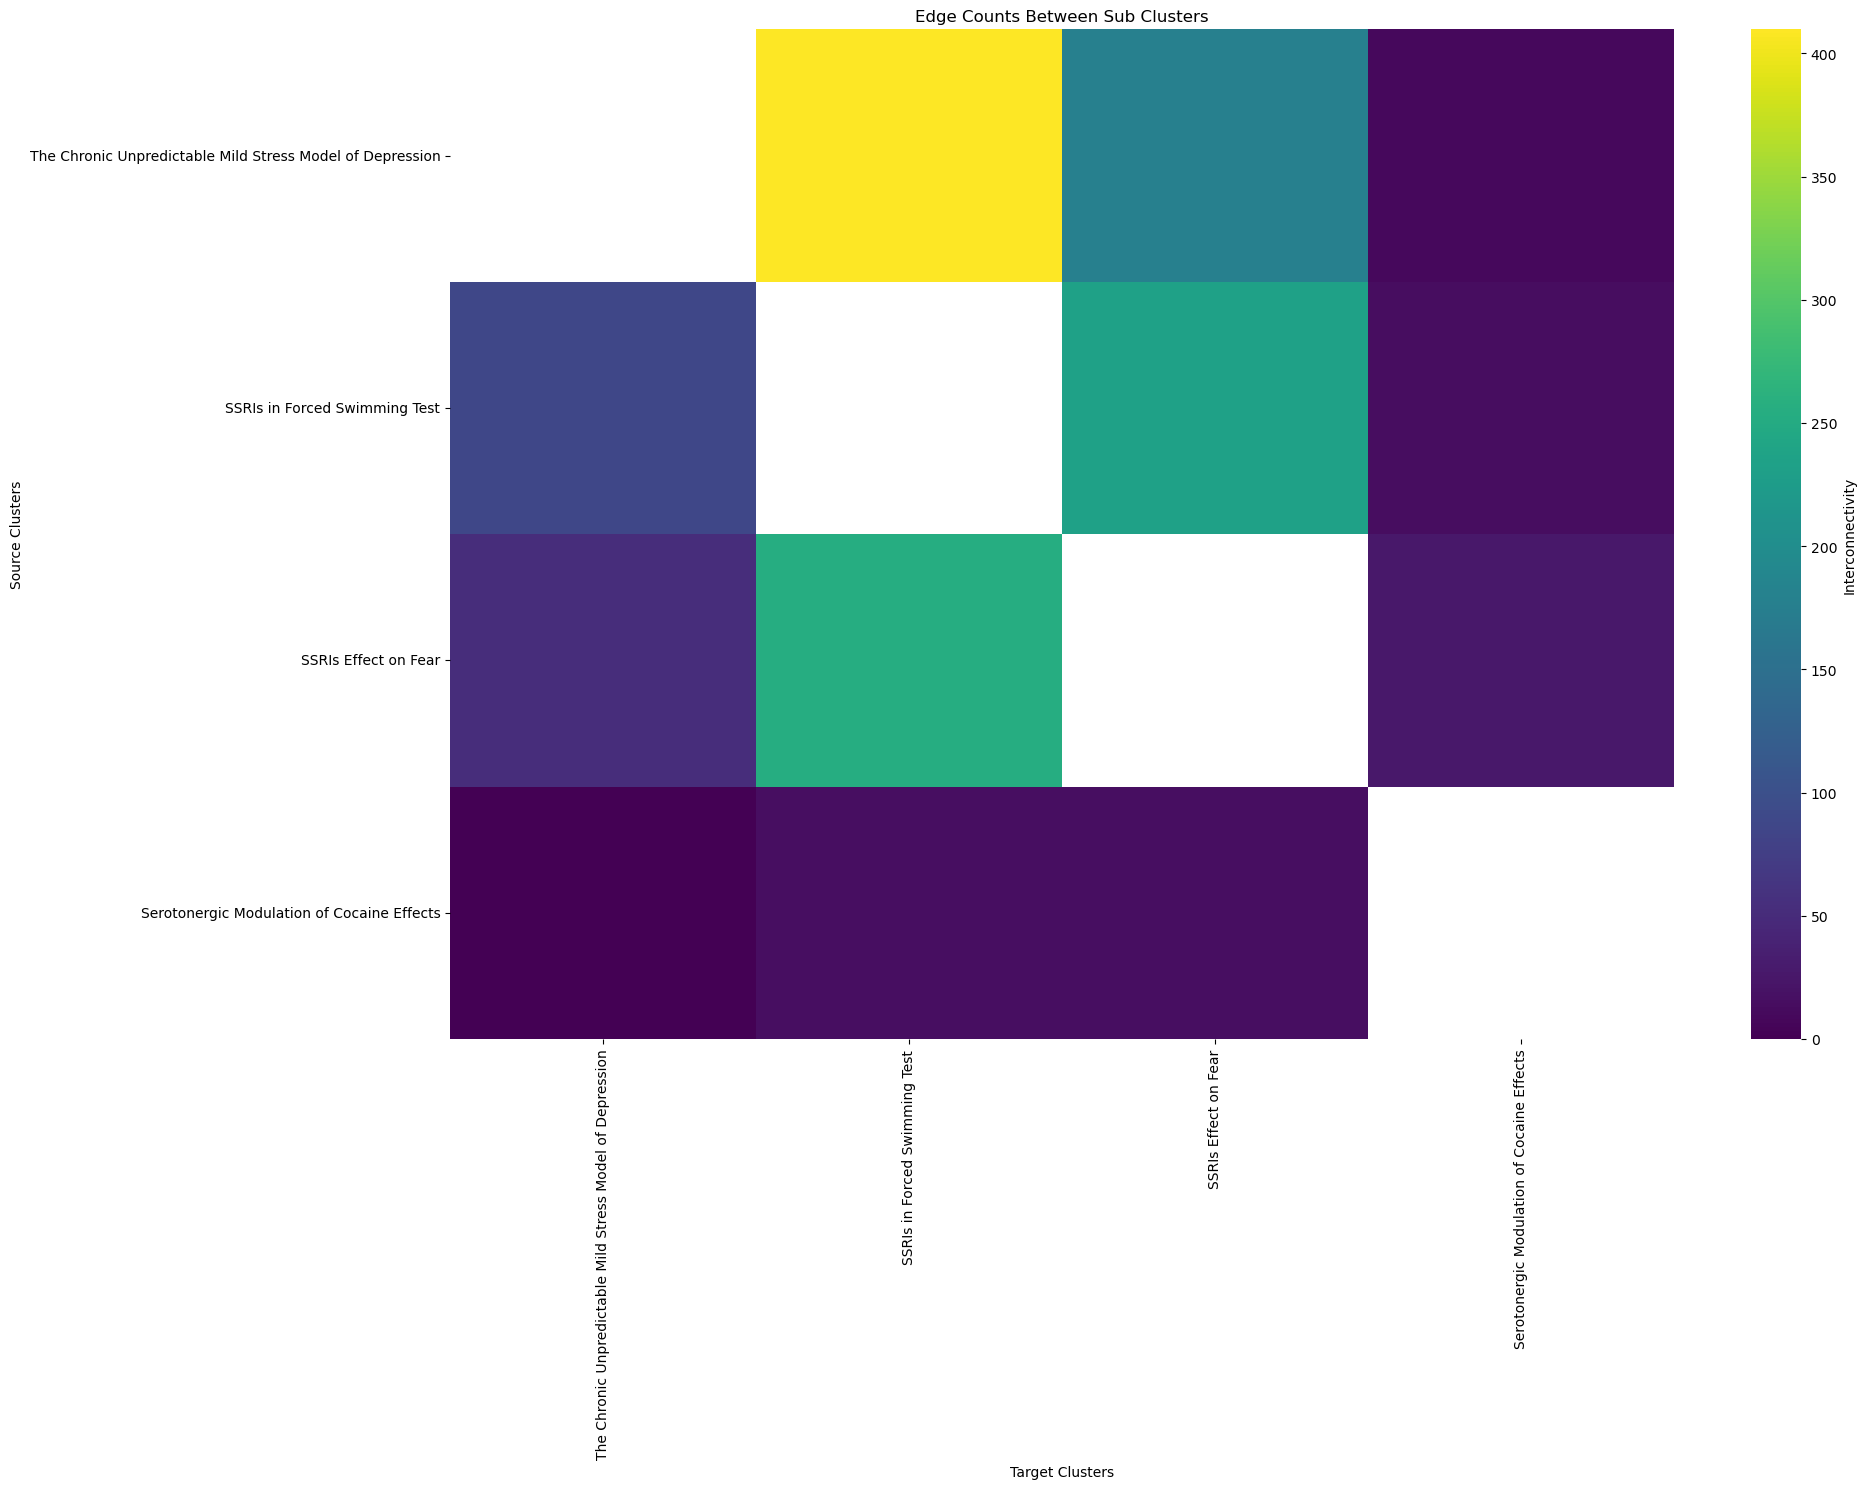

In [31]:

# Initialize analyzer
analyzer_subset = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer_subset.load_data()

# Create interconnectivity matrices
edge_counts_df_pharma, normalized_df_pharma = analyzer_subset.create_cluster_interconnectivity_matrix(pharma_keys)
# Create interconnectivity matrices
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics_pharma = analyzer_subset.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
cluster_metrics_pharma = pd.DataFrame.from_dict(cluster_metrics_pharma, orient="index")
cluster_metrics_pharma.index.name = "cluster"
cluster_metrics_pharma = cluster_metrics_pharma.sort_index()

# Print summary statistics
analyzer_subset.print_metrics_summary(metrics_df=cluster_metrics_pharma)
# Plot heatmap for pharma clusters
analyzer_subset.plot_heatmap(edge_counts_df_pharma, "Sub", diag_excluded=True, cap_max_percentile=99)

DataFrame loaded with rows: 36510
Cluster labels loaded with 99 entries.
Legend loaded with 4 entries.
Edge counts matrix created successfully

Cluster Interconnectivity Summary:
--------------------------------------------------
Total number of clusters: 99
Average cluster size: 368.79
Average internal edge ratio: 0.498
Average external edge ratio: 0.502


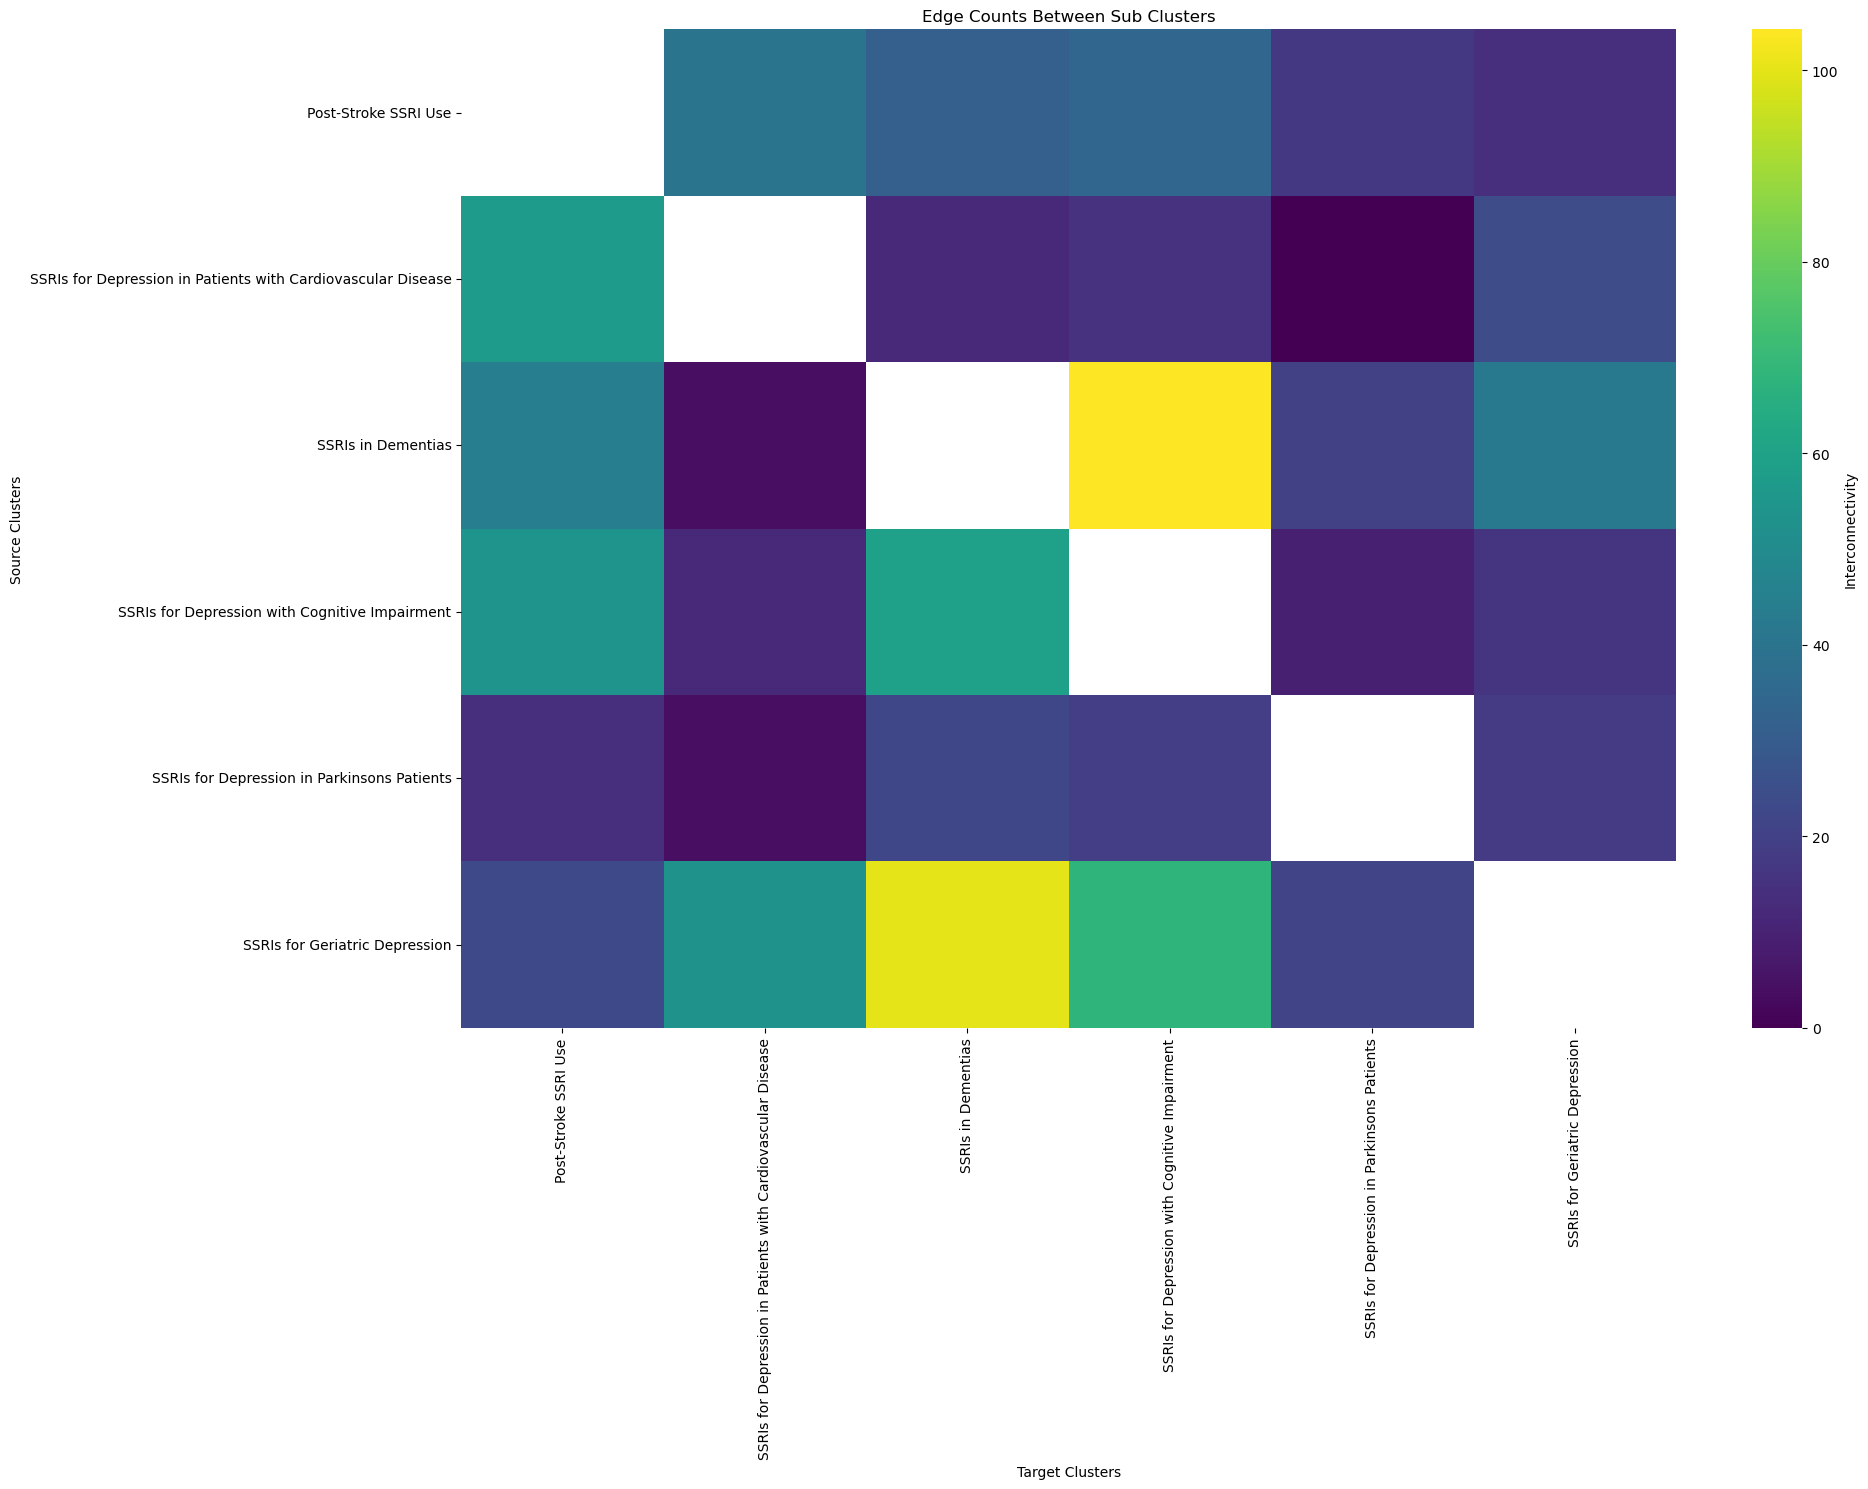

In [32]:
# Initialize analyzer
analyzer_geriatrics = ClusterAnalyzer(data_dir, output_dir)

# load analyses
analyzer_geriatrics.load_data()

# Create interconnectivity matrices
edge_counts_df_geriatrics, normalized_df_geriatrics = analyzer_geriatrics.create_cluster_interconnectivity_matrix(geriatrics_keys)
# Create interconnectivity matrices
print("Edge counts matrix created successfully")

# Analyze cluster interconnectivity
cluster_metrics_geriatrics = analyzer_geriatrics.analyze_cluster_interconnectivity()

# Convert cluster metrics to DataFrame for easier analysis
cluster_metrics_geriatrics = pd.DataFrame.from_dict(cluster_metrics_geriatrics, orient="index")
cluster_metrics_geriatrics.index.name = "cluster"
cluster_metrics_geriatrics = cluster_metrics_geriatrics.sort_index()

# Print summary statistics
analyzer_geriatrics.print_metrics_summary(metrics_df = cluster_metrics_geriatrics)
# Plot heatmap for all clusters
analyzer_geriatrics.plot_heatmap(edge_counts_df_geriatrics, "Sub", diag_excluded=True, cap_max_percentile=99)

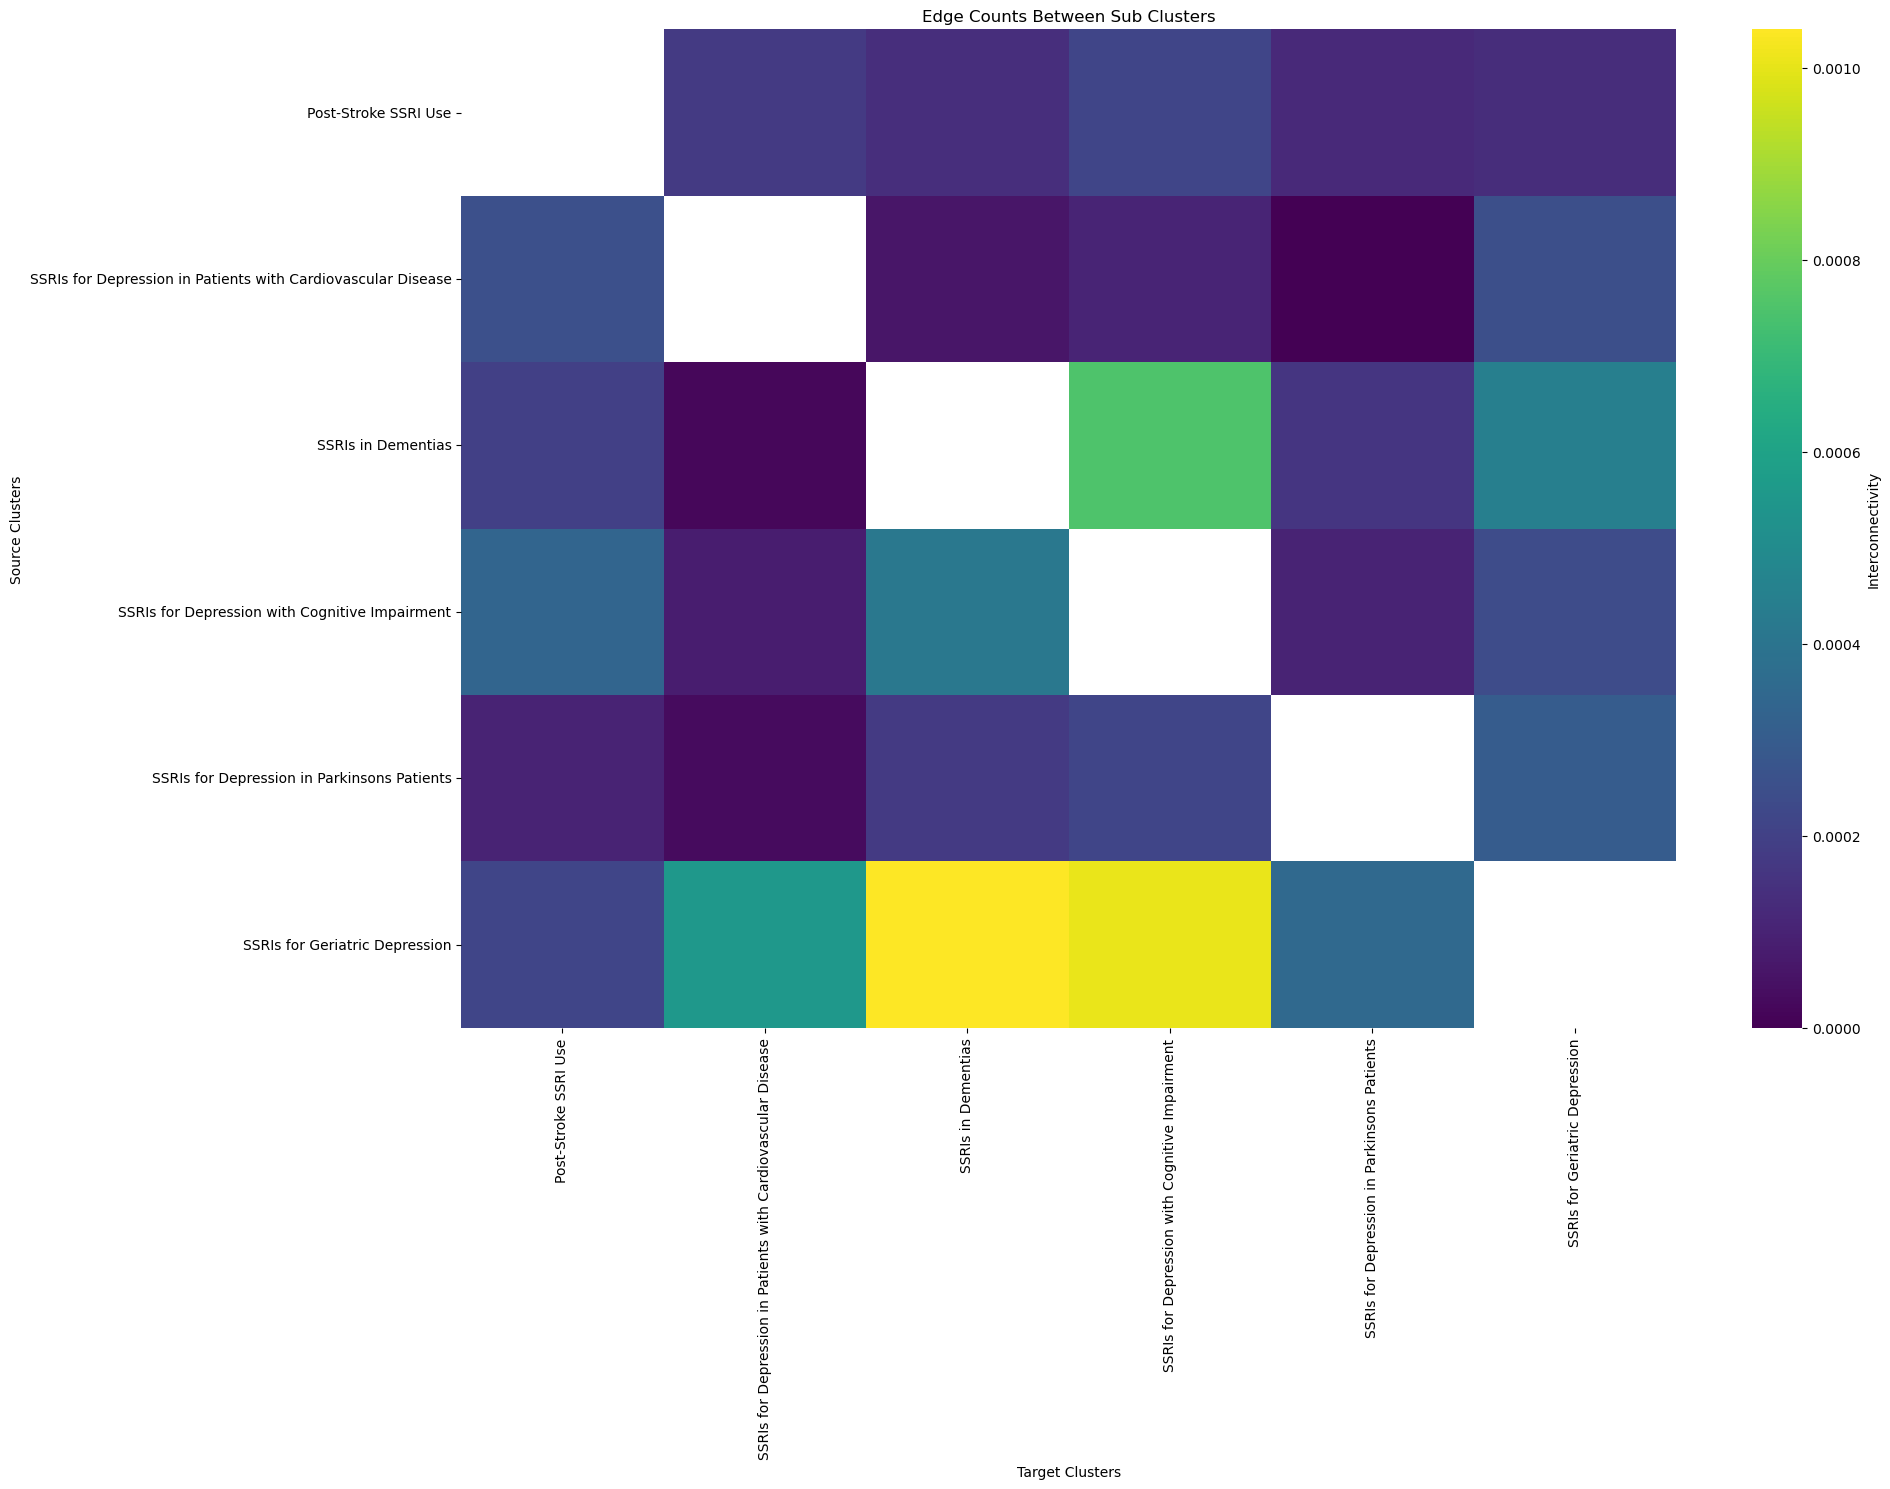

In [33]:
analyzer_geriatrics.plot_heatmap(normalized_df_geriatrics, "Sub", diag_excluded=True, cap_max_percentile=99)